# №1	Форма оплаты и средний чек

**Определение гипотез**

H₀: Средний чек не зависит от формы оплаты (наличные / безналичные).  
H₁: Средний чек различается в зависимости от формы оплаты.  

**Тесты**  
- Kruskal-Wallis H-test  
    - Размер эффекта Cliff's Delta
- Student’s t-test на логарифмически преобразованных данных (предпосылки не выполнены)
    - Shapiro–Wilk test
    - D’Agostino & Pearson test
    - Levene's test
    - Проверка скоса (skewness) и эксцесса (kurtosis)
- Welch's t-test на логарифмически преобразованных данных

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import configparser
from scipy.stats import mannwhitneyu, ttest_ind
from scipy.stats import levene, ttest_ind
from scipy.stats import skew, kurtosis
import scipy.stats as stats
from scipy.stats import kruskal
from cliffs_delta import cliffs_delta
from scipy.stats import shapiro, normaltest
# Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [2]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query = 'SELECT * FROM sales'
data = db_connection.execute_query(query)

### Подготовка данных

In [3]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

### Формирование чеков

In [4]:
# Цена без учета размера скидки
cleaned_data.loc[:, 'price_without_discount'] = cleaned_data['dr_croz'] * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_apt', 'dr_nchk', 'dr_dat']).agg({'price_without_discount':'sum',\
                                                            'dr_sdisc':'max', 'dr_tpay':'max'}).reset_index()
# Цена товара с учетом скидки
grouped['final_price'] = grouped['price_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_apt,dr_nchk,dr_dat,price_without_discount,dr_sdisc,dr_tpay,final_price
0,2,1,2022-06-02,1282.0,0.00,15,1282.00
1,2,3,2022-06-02,208.0,6.00,15,202.00
2,2,5,2022-06-02,2124.0,36.52,15,2087.48
3,2,7,2022-06-02,95.0,0.00,18,95.00
4,2,9,2022-06-02,4018.0,200.00,15,3818.00


### EDA

**Статистика по группам:**

In [5]:
grouped.groupby('dr_tpay')['final_price'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,dr_tpay,mean,median,count
0,15,542.34,279.0,7897
1,18,611.67,347.0,13025


**Визуализация распределений**

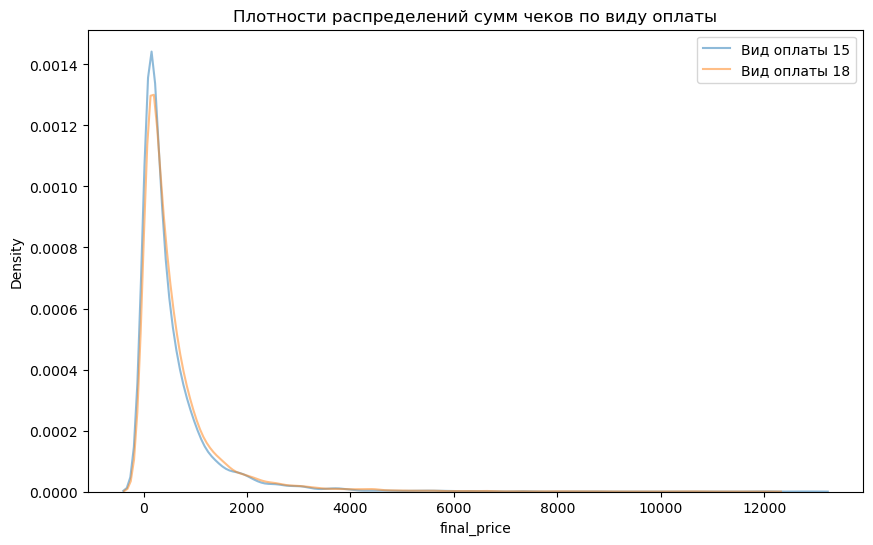

In [6]:
# Группировка по сотрудникам
groups = grouped.groupby('dr_tpay')['final_price']

# 1. -- Визуализация плотностей KDE
plt.figure(figsize=(10, 6))
for name, group in groups:
    sns.kdeplot(group, label=f"Вид оплаты {name}", alpha=0.5)
plt.title("Плотности распределений сумм чеков по виду оплаты")
plt.xlabel("final_price")
plt.legend(loc='best')
plt.show()

- Все кривые имеют пик вблизи нуля – нескольких сотен рублей, следовательно, большинство чеков в обеих группах находится в этой зоне.
- Хвосты (справа) длинные, есть редкие большие чеки (до 30 000 - 35 000).
- Форма в обеих группах очень похожа: узкий высокий пик + длинный правый хвост.  

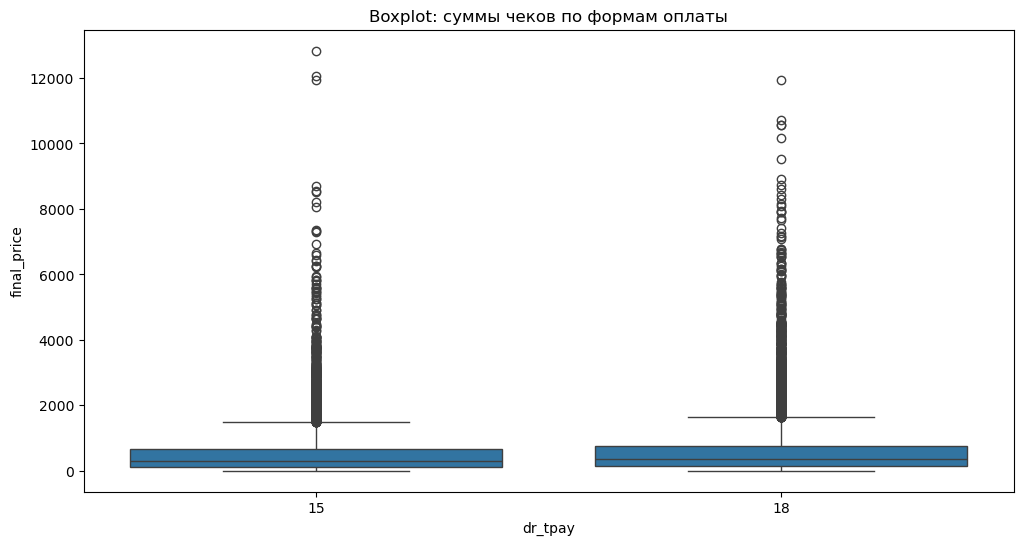

In [7]:
# 2. --Boxplot — сравнение распределений по медианам и разбросу
plt.figure(figsize=(12, 6))
sns.boxplot(x="dr_tpay", y="final_price", data=grouped)
plt.title("Boxplot: суммы чеков по формам оплаты")
plt.show()

1. Форма ящиков примерно одинакова:  
- Ширина IQR (межквартильного размаха) похожа.  
- Расстояние между медианой и краями ящика визуально схоже.  
2. Медианы незначительно различаются.  
3. Усы также примерно одинаковой длины, следовательно разброс внутри групп схож.  
4. Аномалии/выбросы (точки) присутствуют во всех группах, но в похожем объёме и диапазоне.  

**Формирование выборок**

In [8]:
# Подготовка данных
cash_values = grouped.loc[grouped['dr_tpay'] == 15, 'final_price'].dropna().to_numpy()
card_values = grouped.loc[grouped['dr_tpay'] == 18, 'final_price'].dropna().to_numpy()

## Kruskal-Wallis H-test

### Проверка предпосылок

На основании boxplot и kdeplot можно утверждать, что предпосылка Kruskal-Wallis о сходстве форм распределения соблюдена.   
Распределения сумм чеков по форме оплаты выглядят похожими по форме, схожими по разбросу и отличаются в основном по медианам.    

### Проведение Kruskal-Wallis H-test

In [9]:
# ============================
# 1. Kruskal-Wallis
# ============================
stat, p = kruskal(cash_values, card_values)
print("\n=== Kruskal-Wallis тест ===")
print("Kruskal-Wallis H-test: stat=%.3f, p=%.5f" % (stat, p))

# Интерпретация
alpha = 0.05
if p < alpha:
    print("Отвергаем H0: различия статистически значимы.")
else:
    print("Не отвергаем H0: статистически значимых различий не выявлено.")

# ============================
# 2. Cliff's Delta
# ============================
# считаем Cliff's Delta
delta, size = cliffs_delta(cash_values, card_values)
print("\n=== Размер эффекта ===")
print(f"Cliff's Delta: {delta:.3f}")
print(f"Effect size category: {size}")


=== Kruskal-Wallis тест ===
Kruskal-Wallis H-test: stat=108.374, p=0.00000
Отвергаем H0: различия статистически значимы.

=== Размер эффекта ===
Cliff's Delta: -0.086
Effect size category: negligible


**Интерпретация:**

- Статистически значимая разница: Тест Краскала-Уоллиса показал, что средний чек действительно зависит от формы оплаты (наличные или безналичные), то есть существует статистически значимая разница между группами.

- Размер эффекта: Однако размер эффекта, измеренный с помощью Cliff's Delta, крайне мал (-0.086), что означает, что хотя различие статистически значимо, оно на практике не имеет большого значения. Другими словами, форма оплаты влияет на средний чек, но влияние этого фактора настолько мало, что это различие, вероятно, не окажет существенного практического значения.

## Student’s t-test

### Проверка предпосылок

1.	Нормальность распределения.   
- Требование нормальности не выполняется, kdeplot показывает асимметричную  форму и длинный правосторонний хвост распределения.  
- Необходимо применить логарифмическое преобразование (np.log1p).

2.	Равенство дисперсий   
-	Стандартный t-критерий Стьюдента предполагает нормально распределенные данные и равенство дисперсий в сравниваемых группах (гомоскедастичность). Необходимо выполнить проверку.   
-	Если дисперсии существенно различаются — будет использована модифицированная версия — Welch's t-test.

#### Проверка на нормальность

**Логарифмическое преобразование данных**

In [10]:
# ---Лог-преобразование 
# log(1+x), чтобы избежать log(0)
cash_log = np.log1p(cash_values)   
card_log = np.log1p(card_values)

**Визуальная оценка** 

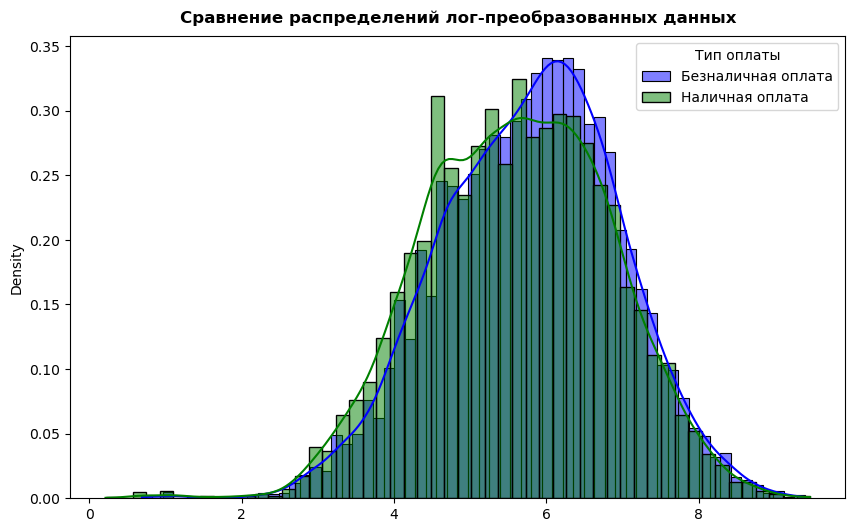

In [11]:
# --- Визуализация лог-преобразованных данных. 
# 1. --Гистограмма 

# Настройка графика
plt.figure(figsize=(10, 6))

# Гистограмма для log-преобразования безналичной оплаты
sns.histplot(x=card_log, color='blue', kde=True, stat='density', alpha=0.5, label='Безналичная оплата')

# Гистограмма для log-преобразования наличной оплаты
sns.histplot(x=cash_log, color='green', kde=True, stat='density', alpha=0.5, label='Наличная оплата')

# Добавление заголовка
plt.title('Сравнение распределений лог-преобразованных данных', fontweight='bold', pad=10)
plt.legend(title='Тип оплаты')
plt.show()

Визуальный анализ показывает, что оба распределения могут иметь отклонения от нормальности и не являются идеально нормальными. 

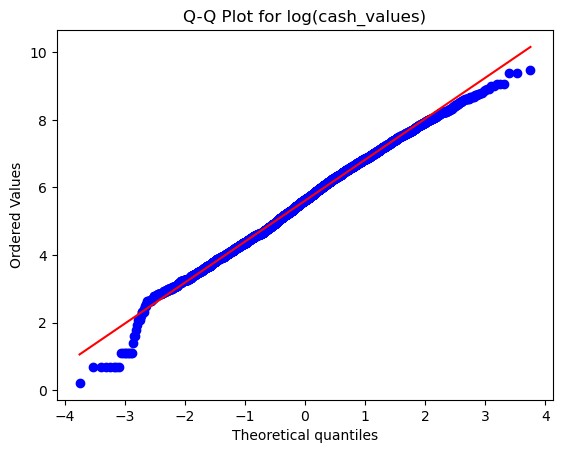

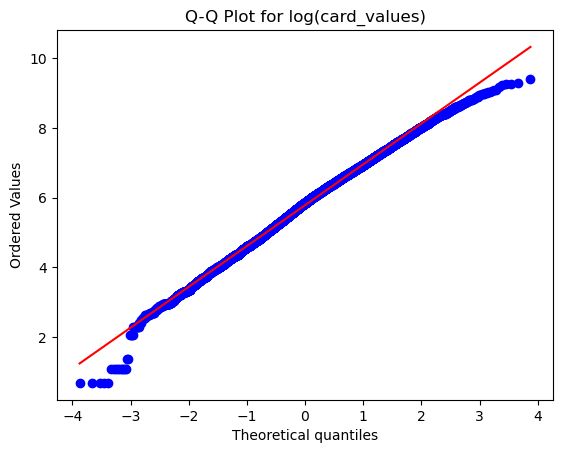

In [12]:
# 2. -- Q–Q Plot (Quantile–Quantile plot)
stats.probplot(cash_log, dist="norm", plot=plt)
plt.title("Q-Q Plot for log(cash_values)")
plt.show()

stats.probplot(card_log, dist="norm", plot=plt)
plt.title("Q-Q Plot for log(card_values)")
plt.show()

1. Q-Q plot для cash_log  
- Большая часть точек (середина распределения) хорошо ложится на красную линию.  
- Небольшие отклонения видны в хвостах:  
    - слева — чуть «поджатый» хвост,  
    - справа — есть выбросы выше линии.  
- Это говорит, что распределение почти нормальное, но хвосты немного тяжелее/легче нормы.  

2. Q-Q plot для card_log  
- Точки ещё лучше ложатся на диагональ, чем у cash_log.  
- Но в нижнем левом углу есть отступления (малые значения), а в верхнем хвосте — небольшие отклонения.  
- В целом оно очень близко к нормальному.  

**Статистические тесты нормальности**

In [13]:
# 1. -- Проверка скоса (skewness) и эксцесса (kurtosis)
print("Skew cash_log:", skew(cash_log))
print("Kurtosis cash_log:", kurtosis(cash_log))
print("Skew card_log:", skew(card_log))
print("Kurtosis card_log:", kurtosis(card_log))

Skew cash_log: -0.11593936118760635
Kurtosis cash_log: -0.07036173352319208
Skew card_log: -0.18551633604010817
Kurtosis card_log: -0.023965693592012283


После лог-преобразования:  
- Распределения стали почти симметричными (skew ≈ 0).  
- Имеют нормальную «высоту» (kurtosis ≈ 0).  
- То есть они стали очень близки к нормальному закону.  

In [14]:
# 2. -- Shapiro–Wilk test
stat, p = shapiro(pd.Series(cash_log).sample(5000, random_state=42))  # лучше брать подвыборку
print("=== Shapiro-Wilk test ===")
print(f"Shapiro test (cash_log): stat={stat:.3f}, p={p:.3f}")
stat, p = shapiro(pd.Series(card_log).sample(5000, random_state=42))  # лучше брать подвыборку
print(f"Shapiro test (card_log): stat={stat:.3f}, p={p:.3f}")

=== Shapiro-Wilk test ===
Shapiro test (cash_log): stat=0.997, p=0.000
Shapiro test (card_log): stat=0.997, p=0.000


При уровне значимости 0.05 p-value для обоих наборов данных существенно меньше 0.05, что приводит к отвержению нулевой гипотезы 
𝐻0 о нормальности распределения данных. Таким образом, можно заключить, что данные cash_log и card_log не следуют нормальному распределению.  
Также, следует заметить, что выборки в данном исследовании являются очень большими (от 7 до 13 тысяч наблюдений). При таких размерах выборки даже незначительные отклонения от нормальности могут стать статистически значимыми, что может привести к неверным выводам при интерпретации теста. Таким образом, несмотря на статистически значимые результаты теста, отклонения от нормальности могут быть настолько малы, что они не имеют существенного практического значения для дальнейшего анализа и могут не влиять на результаты статистических тестов, таких как Welch's t-test, которые являются более устойчивыми к отклонениям от нормальности.

In [15]:
# 3. -- D’Agostino & Pearson test
stat, p = normaltest(cash_log)
print("=== D'Agostino and Pearson's test ===")
print(f"Normaltest (cash_log): stat={stat:.3f}, p={p:.3f}")
stat, p = normaltest(card_log)
print(f"Normaltest (card_log): stat={stat:.3f}, p={p:.3f}")

=== D'Agostino and Pearson's test ===
Normaltest (cash_log): stat=19.255, p=0.000
Normaltest (card_log): stat=73.832, p=0.000


Поскольку p-value для обеих выборок значительно меньше 0.05, нулевая гипотеза о нормальности распределения данных отвергается. Это указывает на то, что данные cash_log и card_log не подчиняются нормальному распределению.
Однако, учитывая большие размеры выборок (7–13 тысяч наблюдений), даже незначительные отклонения от нормальности могут быть статистически значимыми. Таким образом, хотя тесты показывают значимые отклонения от нормальности, эти отклонения могут быть минимальными и не иметь существенного влияния на дальнейший анализ.

**Интерпретация результатов**   
Данные после лог-преобразования визуально и по моментам (skew, kurtosis) близки к нормальному распределению, однако формальные тесты (Shapiro, D’Agostino) при большом размере выборки показывают статистически значимые отклонения. 

#### Проверка равенства дисперсий  

In [16]:
# --- Проверка равенства дисперсий
stat, p = levene(cash_log, card_log)
print("=== Levene's test ===")
print(f"Levene test: stat={stat:.3f}, p={p:.3f}")

=== Levene's test ===
Levene test: stat=20.157, p=0.000


**Интерпретация результатов**   
Поскольку дисперсии в лог-преобразованных данных различаются, применение стандартного t-теста для независимых выборок с одинаковыми дисперсиями не является корректным. В связи с этим, необходимо использовать Welch's t-test, который не требует равенства дисперсий и является более подходящим для данной ситуации. Кроме того, Welch's t-test не предъявляет строгих требований к нормальности данных.

## Welch’s t-test

### Проверка предпосылок

Оба распределения достаточно близки к нормальному. Welch’s t-test является робастным к умеренным отклонениям от нормальности, особенно при средних или больших выборках (n > 30). Поэтому мы можем считать, что условия для Welch’s t-test выполнены, и его можно применять к этим данным.

### Проведение теста

In [17]:
# ============================
# 1. Welch’s t-test
# ============================

t_stat, t_p = ttest_ind(cash_log, card_log, equal_var=False)
print("=== Welch t-test ===")
# Вывод результатов
print(f"t-статистика: {t_stat}")
print(f"p-значение: {t_p}")


# Интерпретация результатов
alpha = 0.05  # Уровень значимости
if t_p < alpha:
    print("Отвергаем нулевую гипотезу: различия статистически значимы.")
else:
    print("Не отвергаем нулевую гипотезу: различия незначимы.")


=== Welch t-test ===
t-статистика: -10.318242938574874
p-значение: 6.959812544494983e-25
Отвергаем нулевую гипотезу: различия статистически значимы.


**Результат**  

1. Статистические тесты Kruskal–Wallis и Welch t-test показали:  
-  p-value ≈ 0.000, различия между группами существуют и они не случайны.  
  
2. Cliff’s Delta = -0.086, эффект незначительный (negligible).  
- То есть разница есть, но она очень мала по силе.  
- Если взять случайного клиента, то вероятность того, что чек по карте будет выше, чем по наличке, лишь незначительно отличается от 50%.  

3. Средние значения:  
- наличные: 548 ₽  
- карта: 614 ₽  
Разница ≈ 66 ₽.  

**Значение для бизнеса**  
Безналичные платежи ассоциируются с чуть более высоким средним чеком, но:  
- эффект микроскопический;  
- статистическая значимость получилась из-за большого объёма выборки (13k + 8k чеков), а не из-за реально ощутимой разницы.  

**Рекомендации**  
Форма оплаты влияет на средний чек, но влияние крайне слабое.  
Клиенты с картой тратят немного больше, но разница незначительна.  
Не стоит строить стратегию продаж исключительно вокруг формы оплаты.  
Сильного роста выручки только за счёт стимулирования оплаты картой ожидать нельзя.  